In [1]:
%matplotlib inline
import waves
import matplotlib.pyplot as plt
import numpy as np

A/D conversion
=============

In [2]:
CD = waves.CDFormatSampler('CD')

SACD = waves.DSDSampler('SACD', 64 * 44100, 16)

# DVD possible combinations (16-, 20- or 24-bits per sample)
# Channels                          | 44.1 kHz | 48 kHz | 88.2 kHz | 96 kHz | 176.4 kHz | 192 kHz
# Mono (1.0)                        |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.0)                      |    Yes   |  Yes   |    Yes   |  Yes   |    Yes    |   Yes   
# Stereo (2.1)                      |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# S+M surround (3.0 or 3.1)         |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Quad (4.0 or 4.1)                 |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo (3.0 or 3.1)             |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# 3-stereo+M surround (4.0 or 4.1)  |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
# Full surround (5.0 or 5.1)        |    Yes   |  Yes   |    Yes   |  Yes   |    No     |   No   
DVDA = waves.PCMSampler('DVD Audio', 88200, 20)

# High Fidelity Blu-ray Pure Audio uses 24 bits at 192 kHz (or also 96 kHz)
BDA = waves.HFPALinearPCM('Blu-Ray Audio')

# Generic, define sampling frequency (Hz) and resolution (bits) to your heart's content
GenericPCM_1 = waves.PCMSampler('Generic 1', 44100, 4) # Same CD frequency, lower resolution
GenericPCM_2 = waves.PCMSampler('Generic 2', 14000, 16) # Same CD resolution, lower frequency

CD's stream: [32768 36645 40444 44087 47501 50616 53369 55705 57577 58945 59783 60074
 59811 59000 57657 55810 53497 50763 47664 44264 40630 36837 32962 29083
 25278 21626 18199 15067 12294  9936  8040  6646  5781  5463  5698  6482
  7798  9621 11912 14627 17708 21095 24719 28505 32378]
Generic 1's stream: [ 8  8  9 10 11 12 12 13 13 13 14 14 14 14 13 13 12 12 11 10  9  8  8  7
  6  5  4  3  3  2  2  2  1  1  1  1  2  2  3  3  4  5  6  7  7]
Generic 2's stream: [32768 44615 54116 59389 59389 54116 44615 32768 20920 11419  6146  6146
 11419 20920]


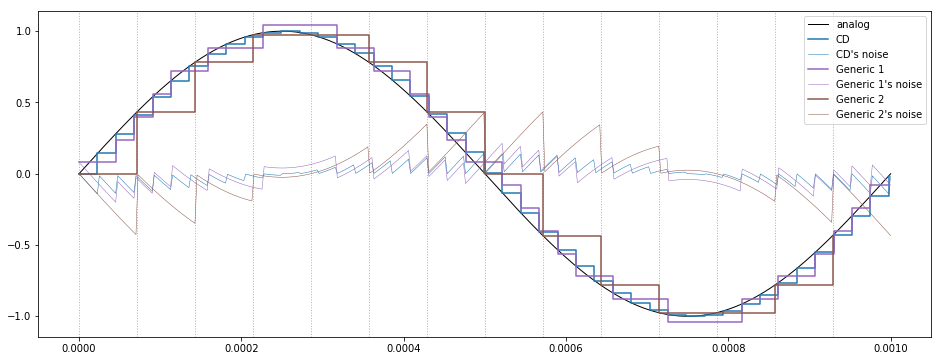

In [7]:
f = 1e3 # 1KHz
audio = waves.AnalogSineWave('analog', f, gain=1, phase=0)
n_waves = 1
length = n_waves * 1/f

noise_nodither = {}
noise_nodither['time_domain'] = audio.plot(length, plt, color='k', lw=1)
_, _, _, noise_nodither[CD.label] = CD.sample(audio, length, plt, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
_, _, _, noise_nodither[GenericPCM_1.label] = GenericPCM_1.sample(audio, length, plt, lw=1.5)
_, _, _, noise_nodither[GenericPCM_2.label] = GenericPCM_2.sample(audio, length, plt, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
#[plt.axhline(A, color='b', lw=1, ls=':', alpha=0.5) for A in np.linspace(audio.Amin, audio.Amax, GenericPCM.levels)]
plt.legend();
plt.gcf().set_size_inches(16, 6)

Let us now add some dither and see how the noise behaves

CD's stream: [31761 37656 42919 41163 48060 51091 49209 55098 62921 53245 65380 58679
 61114 52968 54908 56835 54778 47865 54765 47862 49083 28788 33801 21719
 22296 29581 11374 18445  6918 15309  4182  8545  7624  5374  3403     0
  6645  6784 16016 15073 13617 23367 22759 34381 23943]
Generic 1's stream: [ 8  7  9 12 12 12 12 13 12 14 14 13 14 13 14 13 13 12 12  9  9  7  7  7
  5  5  3  5  3  3  3  2  0  2  2  2  0  3  2  5  5  5  7  6  8]
Generic 2's stream: [36236 37908 56865 59122 58227 52909 39664 35969 24604  6936 10039 11086
 18045 25542]


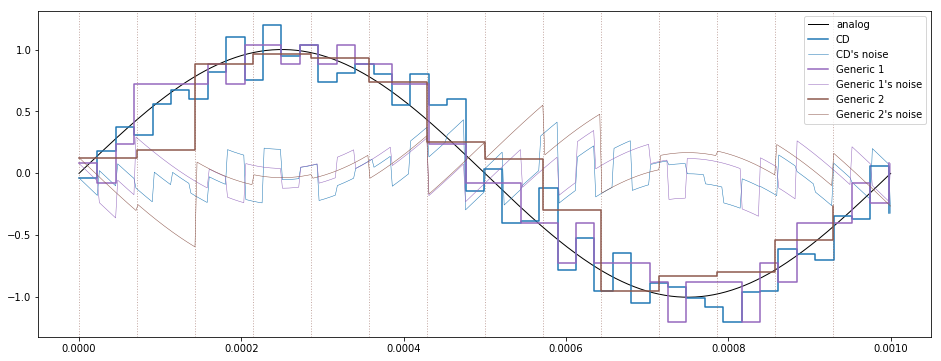

In [8]:
noise_dither = {}
noise_dither['time_domain'] = audio.plot(length, plt, color='k', lw=1)
_, _, _, noise_dither[CD.label] = CD.sample(audio, length, plt, dither=0.35, lw=1.5)
##SACD.sample(audio, length, plt, color='b', lw=1.5)
#DVDA.sample(audio, length, plt, color='g', lw=1.5)
#BDA.sample(audio, length, plt, color='m', lw=1.5)
_, _, _, noise_dither[GenericPCM_1.label] = GenericPCM_1.sample(audio, length, plt, dither=0.35, lw=1.5)
_, _, _, noise_dither[GenericPCM_2.label] = GenericPCM_2.sample(audio, length, plt, dither=0.35, lw=1.5)
[plt.axvline(t, color=GenericPCM_2.color, lw=1, ls=':', alpha=0.5) for t in np.arange(0, length, GenericPCM_2.sampling_interval)]
#[plt.axhline(A, color='b', lw=1, ls=':', alpha=0.5) for A in np.linspace(audio.Amin, audio.Amax, GenericPCM.levels)]
plt.legend()
plt.gcf().set_size_inches(16, 6)

The noise is now more decorrelated from the signal, at the cost of increased noise power. See:

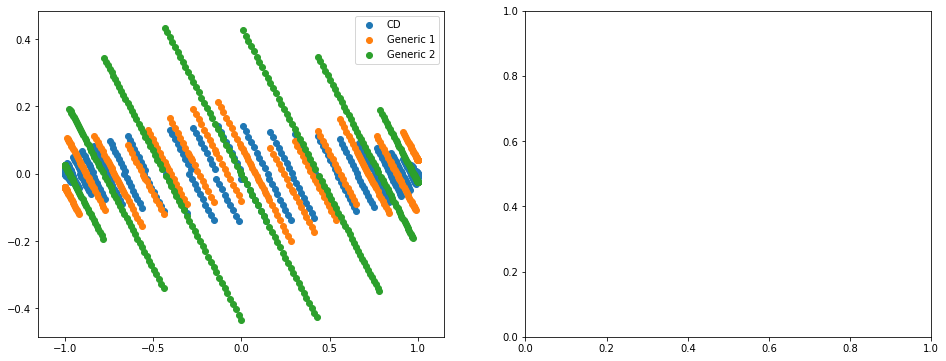

In [15]:
fig, ax = plt.subplots(1, 2)
for ADC in [CD, GenericPCM_1, GenericPCM_2]:
    ax[0].scatter(audio.function(noise_nodither['time_domain']), noise_nodither[ADC.label], label=ADC.label)
ax[0].legend()
fig.set_size_inches(16, 6)

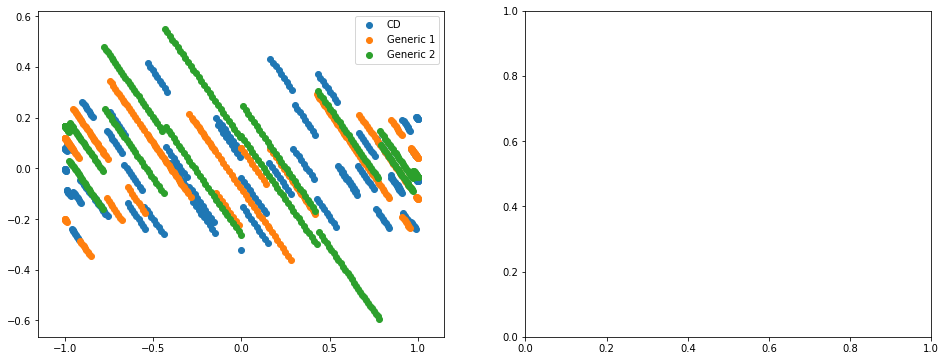

In [16]:
fig, ax = plt.subplots(1, 2)
for ADC in [CD, GenericPCM_1, GenericPCM_2]:
    ax[0].scatter(audio.function(noise_dither['time_domain']), noise_dither[ADC.label], label=ADC.label)
ax[0].legend()
fig.set_size_inches(16, 6)